In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

In [2]:
pd.set_option('display.max_columns',None)

Problem Statement:
According to air travel consumer reports, a large proportion of consumer complaints are about frequent flight delays. Out of all the complaints received from consumers about airline services, 32% were related to cancellations, delays, or other deviations from the airlines’ schedules. There are unavoidable delays that can be caused by air traffic, no passengers at the airport, weather conditions, mechanical issues, passengers coming from delayed connecting flights, security clearance, and aircraft preparation.

Objective:
The objective of this project is to identify the factors that contribute to avoidable flight delays.
You are also required to build a model to predict if the flight will be delayed.

# Import and aggregate

## Collect data related to flights, airports (e.g., type of airport and elevation), and runways (e.g., length_ft, width_ft, surface, and number of runways) considering fields you believe might cause avoidable delays in one dataset

In [3]:
airlines = pd.read_excel('Airlines.xlsx')
airports = pd.read_excel('airports.xlsx')
runways = pd.read_excel('runways.xlsx')

In [4]:
airlines.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [5]:
airports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,NaN,NaN,NaN,NaN,NaN,00AR


In [6]:
runways.head()

,id,airport_ref,airport_ident,length_ft,width_ft,surface,lighted,closed,le_ident,le_latitude_deg,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
0,269408,6523,00A,80.0,80.0,ASPH-G,1,0,H1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,255155,6524,00AK,2500.0,70.0,GRVL,0,0,N,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
2,254165,6525,00AL,2300.0,200.0,TURF,0,0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN
3,270932,6526,00AR,40.0,40.0,GRASS,0,0,H1,NaN,NaN,NaN,NaN,NaN,H1,NaN,NaN,NaN,NaN,NaN
4,322128,322127,00AS,1450.0,60.0,Turf,0,0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN


Now we merge airports and runways and create airpt_run using the ident column in airports, and the airport_ident column in runways. We are doing a left join i.e. all of airports columns and only the matching values from runways will be imported.

In [7]:
airpt_run = pd.merge(airports, runways, left_on = 'ident', right_on = 'airport_ident', how = 'left')
airpt_run.head()

,id_x,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,id_y,airport_ref,airport_ident,length_ft,width_ft,surface,lighted,closed,le_ident,le_latitude_deg,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN,269408.0,6523.0,00A,80.0,80.0,ASPH-G,1.0,0.0,H1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN,255155.0,6524.0,00AK,2500.0,70.0,GRVL,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN,254165.0,6525.0,00AL,2300.0,200.0,TURF,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,NaN,NaN,NaN,NaN,NaN,00AR,270932.0,6526.0,00AR,40.0,40.0,GRASS,0.0,0.0,H1,NaN,NaN,NaN,NaN,NaN,H1,NaN,NaN,NaN,NaN,NaN


In [8]:
airpt_run.columns

Index(['id_x', 'ident', 'type', 'name', 'latitude_deg', 'longitude_deg',
       'elevation_ft', 'continent', 'iso_country', 'iso_region',
       'municipality', 'scheduled_service', 'gps_code', 'iata_code',
       'local_code', 'home_link', 'wikipedia_link', 'keywords', 'id_y',
       'airport_ref', 'airport_ident', 'length_ft', 'width_ft', 'surface',
       'lighted', 'closed', 'le_ident', 'le_latitude_deg', 'le_longitude_deg',
       'le_elevation_ft', 'le_heading_degT', 'le_displaced_threshold_ft',
       'he_ident', 'he_latitude_deg', 'he_longitude_deg', 'he_elevation_ft',
       'he_heading_degT', 'he_displaced_threshold_ft'],
      dtype='object')

Here we count the number of runways each airport has. To do this we will group the rows based on the common airport_ident values while keeping a count of the non-null values in id_y which has the runway entries of a particular airport.

In [9]:
cnt_run = airpt_run.groupby('airport_ident')[['id_y']].count().sort_values(by = 'id_y', ascending = False).reset_index()
cnt_run.head()

,airport_ident,id_y
0,KORD,11
1,KNHU,10
2,JRA,9
3,TA12,8
4,SXS,8


Now that we have a count of runways for each airport, let's create a new dataset containing airport iata_code, type of airport, elevation of airport, and the number of runways all of which could play a role in delays.

In [10]:
air_run = pd.merge(airports, cnt_run, left_on = 'ident', right_on = 'airport_ident', how = 'left')
air_run.rename(columns = {'id_y' : 'runway_cnt'}, inplace= True )
air_run.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,airport_ident,runway_cnt
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN,00A,1.0
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN,00AK,1.0
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN,00AL,1.0
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,NaN,NaN,NaN,NaN,NaN,00AR,00AR,1.0


In [11]:
air_run=air_run[['iata_code', 'type', 'elevation_ft', 'runway_cnt']]
air_run.head()

,iata_code,type,elevation_ft,runway_cnt
0,NaN,heliport,11.0,1.0
1,NaN,small_airport,3435.0,NaN
2,NaN,small_airport,450.0,1.0
3,NaN,small_airport,820.0,1.0
4,NaN,closed,237.0,1.0


In [12]:
air_run.shape

(73805, 4)

In [13]:
air_run.isnull().sum()

iata_code       64645
type                0
elevation_ft    14122
runway_cnt      36540
dtype: int64

In [14]:
air_run.dropna().to_excel('air_run.xlsx', index = False)

By merging the airlines and air_run datasets according to the AirportFrom and iata_code columns, we can add information on the AirportFrom values. This will provide the elevation, iata_code, and number of runways of the airports from which flights depart. We can repeat the same for destination airports.

In [15]:
cmbd_df = pd.merge(airlines, air_run, how = 'left', left_on = 'AirportFrom', right_on = 'iata_code')
new_names = list(cmbd_df[air_run.columns].columns + '_source_airport')
old_names = list(cmbd_df[air_run.columns].columns)
cmbd_df.rename(columns = {old:new for old, new in zip(old_names, new_names)}, inplace = True)
cmbd_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,iata_code_source_airport,type_source_airport,elevation_ft_source_airport,runway_cnt_source_airport
0,1,CO,269,SFO,IAH,3,15,205,1,SFO,large_airport,13.0,4.0
1,2,US,1558,PHX,CLT,3,15,222,1,PHX,large_airport,1135.0,3.0
2,3,AA,2400,LAX,DFW,3,20,165,1,LAX,large_airport,125.0,4.0
3,4,AA,2466,SFO,DFW,3,20,195,1,SFO,large_airport,13.0,4.0
4,5,AS,108,ANC,SEA,3,30,202,0,ANC,large_airport,152.0,3.0


In [16]:
cmbd_df.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'iata_code_source_airport',
       'type_source_airport', 'elevation_ft_source_airport',
       'runway_cnt_source_airport'],
      dtype='object')

In [17]:
cmbd_df = pd.merge(cmbd_df, air_run, how = 'left', left_on = 'AirportTo', right_on = 'iata_code')
new_names = list(cmbd_df[air_run.columns].columns + '_dest_airport')
old_names = list(cmbd_df[air_run.columns].columns)
cmbd_df.rename(columns = {old:new for old, new in zip(old_names, new_names)}, inplace = True)
cmbd_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,iata_code_source_airport,type_source_airport,elevation_ft_source_airport,runway_cnt_source_airport,iata_code_dest_airport,type_dest_airport,elevation_ft_dest_airport,runway_cnt_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,SFO,large_airport,13.0,4.0,IAH,large_airport,97.0,5.0
1,2,US,1558,PHX,CLT,3,15,222,1,PHX,large_airport,1135.0,3.0,CLT,large_airport,748.0,4.0
2,3,AA,2400,LAX,DFW,3,20,165,1,LAX,large_airport,125.0,4.0,DFW,large_airport,607.0,7.0
3,4,AA,2466,SFO,DFW,3,20,195,1,SFO,large_airport,13.0,4.0,DFW,large_airport,607.0,7.0
4,5,AS,108,ANC,SEA,3,30,202,0,ANC,large_airport,152.0,3.0,SEA,large_airport,433.0,4.0


In [18]:
cmbd_df.drop(columns = ['iata_code_source_airport', 'iata_code_dest_airport'], inplace = True)

In [19]:
cmbd_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_cnt_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_cnt_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0
2,3,AA,2400,LAX,DFW,3,20,165,1,large_airport,125.0,4.0,large_airport,607.0,7.0
3,4,AA,2466,SFO,DFW,3,20,195,1,large_airport,13.0,4.0,large_airport,607.0,7.0
4,5,AS,108,ANC,SEA,3,30,202,0,large_airport,152.0,3.0,large_airport,433.0,4.0


## When it comes to on-time arrivals, different airlines perform differently based on the amount of experience they have. The major airlines in this field include US Airways Express (founded in 1967), Continental Airlines (founded in 1934), and Express Jet (founded in 19860. Pull such information specific to various airlines from the Wikipedia page link given below.
https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States.


In [20]:
# Extracting the number of tables in the URL.

air_xp_url = requests.get('https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States').text
soup = BeautifulSoup(air_xp_url, 'lxml')
tables_found = soup.findAll("table",{"class":"wikitable"})

In [21]:
len(tables_found)

7

In [22]:
airlines_wiki_list = []
for i in range(0,7):
    tables = pd.read_html(str(tables_found[i]))
    airlines_wiki_list.append(pd.DataFrame(tables[0]))

In [23]:
airlines_wiki_list[0].columns

Index(['Airline', 'Image', 'IATA', 'ICAO', 'Callsign',
       'Primary hubs, secondary hubs', 'Founded', 'Notes'],
      dtype='object')

In [24]:
airlines_wiki = pd.concat(airlines_wiki_list)

## Combining all the information gathered so far

In [25]:
airlines_founded = pd.merge(cmbd_df[['Airline']].drop_duplicates(), airlines_wiki[['IATA', 'Founded']].drop_duplicates(), how = 'left', left_on = 'Airline', right_on = 'IATA')

In [26]:
airlines_founded

,Airline,IATA,Founded
0,CO,NaN,NaN
1,US,NaN,NaN
2,AA,AA,1926.0
3,AS,AS,1932.0
4,DL,DL,1924.0
5,B6,B6,1998.0
6,HA,HA,1929.0
7,OO,OO,1972.0
8,9E,9E,1985.0
9,OH,OH,1979.0


## The total passenger traffic may also contribute to flight delays. The term hub refers to busy commercial airports. Large hubs are airports that account for at least 1 percent of the total passenger enplanements in the United States. Airports that account for 0.25 percent to 1 percent of total passenger enplanements are considered medium hubs. Pull passenger traffic data from the Wikipedia page given below using web scraping and collate it in a table.
https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States


In [27]:
traffic_url  = requests.get('https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States').text
soup = BeautifulSoup(traffic_url, 'lxml')
traffic_tables = soup.findAll("table", {"class": "wikitable"})

In [28]:
len(traffic_tables)

4

In [29]:
air_hub = []
for i in range(0,4):
    tables = pd.read_html(str(traffic_tables[i]))
    air_hub.append(pd.DataFrame(tables[0]))

In [30]:
large_hubs = air_hub[0]
large_hubs.head()

,Rank (2023),Airports (large),IATA Code,Major cities served,Metro area,State,2023[2],2022[3],2021[4],2020[5],2019[6],2018[7],2017[8],2016[9],2015[10],2014[11]
0,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,Atlanta,GA,50950023,45396001,36676010,20559866,53505795,51865797,50251964,50501858,49340732,46604273
1,2,Dallas/Fort Worth International Airport,DFW,Dallas and Fort Worth,Dallas–Fort Worth,TX,39246196,35345138,30005266,18593421,35778573,32821799,31816933,31283579,31589839,30804567
2,3,Denver International Airport,DEN,Denver,Denver,CO,37863966,33773832,28645527,16243216,33592945,31362941,29809097,28267394,26280043,26000591
3,4,Los Angeles International Airport,LAX,Los Angeles,Greater Los Angeles,CA,36676975,32326616,23663410,14055777,42939104,42624050,41232432,39636042,36351272,34314197
4,5,O'Hare International Airport,ORD,Chicago,Chicagoland,IL,35843081,33120474,26350976,14606034,40871223,39873927,38593028,37589899,36305668,33843426


In [31]:
medium_hubs = air_hub[1]
medium_hubs.head()

,Rank (2023),Airports (medium hubs),IATA Code,City served,Metro Area,State,2023[2],2022[3],2021[4],2020[5],2019[6],2018[7],2017[8],2016[9],2015[10],2014[11]
0,32,Dallas Love Field,DAL,Dallas,Dallas–Fort Worth,TX,8559009,7819129,6487563,3669930,8408457,8134848,7876769,7554596,7040921,4522341
1,33,Portland International Airport,PDX,Portland,Portland,OR,8123024,7241882,5759879,3455877,9797408,9940866,9435473,9071154,8340234,7878760
2,34,St. Louis Lambert International Airport,STL,St. Louis,St. Louis,MO,7307544,6709080,5070471,3041765,7946986,7822274,7372805,6793076,6239231,6108758
3,35,Raleigh–Durham International Airport,RDU,Raleigh,Research Triangle,NC,7118953,5849665,4311049,2337496,6919429,6416822,5851004,5401714,4954717,4673869
4,36,William P. Hobby Airport,HOU,Houston,Houston,TX,6800214,6462948,5560780,3127178,7069614,6937061,6741870,6285181,5937944,5800726


In [32]:
large_hubs['Hub Size'] = "Large Hub"
large_hubs.rename(columns = {'Airports (large)' : 'airport'},inplace = True)
large_hubs.rename(columns = {'Major cities served' : 'city'},inplace = True)
large_hubs

,Rank (2023),airport,IATA Code,city,Metro area,State,2023[2],2022[3],2021[4],2020[5],2019[6],2018[7],2017[8],2016[9],2015[10],2014[11],Hub Size
0,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,Atlanta,GA,50950023,45396001,36676010,20559866,53505795,51865797,50251964,50501858,49340732,46604273,Large Hub
1,2,Dallas/Fort Worth International Airport,DFW,Dallas and Fort Worth,Dallas–Fort Worth,TX,39246196,35345138,30005266,18593421,35778573,32821799,31816933,31283579,31589839,30804567,Large Hub
2,3,Denver International Airport,DEN,Denver,Denver,CO,37863966,33773832,28645527,16243216,33592945,31362941,29809097,28267394,26280043,26000591,Large Hub
3,4,Los Angeles International Airport,LAX,Los Angeles,Greater Los Angeles,CA,36676975,32326616,23663410,14055777,42939104,42624050,41232432,39636042,36351272,34314197,Large Hub
4,5,O'Hare International Airport,ORD,Chicago,Chicagoland,IL,35843081,33120474,26350976,14606034,40871223,39873927,38593028,37589899,36305668,33843426,Large Hub
5,6,John F. Kennedy International Airport,JFK,New York City,New York Metro,NY,30493867,27154885,15273342,8269819,31036655,30620769,29533154,29239151,27782369,26244928,Large Hub
6,7,Orlando International Airport,MCO,Orlando,Orlando,FL,28033177,24469733,19618838,10467728,24562271,23202480,21565448,20283541,18759938,17278608,Large Hub
7,8,Harry Reid International Airport,LAS,Las Vegas,Las Vegas,NV,27896019,25480500,19160342,10584059,24728361,23795012,23364393,22833267,21857693,20620248,Large Hub
8,9,Charlotte Douglas International Airport,CLT,Charlotte,Charlotte,NC,25896193,23100300,20900875,12952869,24199688,22281949,22011251,21511880,21913166,21537725,Large Hub
9,10,Miami International Airport,MIA,Miami,Miami Metro,FL,24716890,23949892,17500096,8786007,21421031,21021640,20709225,20875813,20986349,19471466,Large Hub


In [33]:
medium_hubs['Hub Size'] = "Medium Hub"
medium_hubs.rename(columns = {'Airports (medium hubs)' : 'airport'},inplace = True)
medium_hubs.rename(columns = {'City served' : 'city'},inplace = True)
medium_hubs

,Rank (2023),airport,IATA Code,city,Metro Area,State,2023[2],2022[3],2021[4],2020[5],2019[6],2018[7],2017[8],2016[9],2015[10],2014[11],Hub Size
0,32,Dallas Love Field,DAL,Dallas,Dallas–Fort Worth,TX,8559009,7819129,6487563,3669930,8408457,8134848,7876769,7554596,7040921,4522341,Medium Hub
1,33,Portland International Airport,PDX,Portland,Portland,OR,8123024,7241882,5759879,3455877,9797408,9940866,9435473,9071154,8340234,7878760,Medium Hub
2,34,St. Louis Lambert International Airport,STL,St. Louis,St. Louis,MO,7307544,6709080,5070471,3041765,7946986,7822274,7372805,6793076,6239231,6108758,Medium Hub
3,35,Raleigh–Durham International Airport,RDU,Raleigh,Research Triangle,NC,7118953,5849665,4311049,2337496,6919429,6416822,5851004,5401714,4954717,4673869,Medium Hub
4,36,William P. Hobby Airport,HOU,Houston,Houston,TX,6800214,6462948,5560780,3127178,7069614,6937061,6741870,6285181,5937944,5800726,Medium Hub
5,37,Sacramento International Airport,SMF,Sacramento,Sacramento,CA,6371895,6040824,4760275,2710342,6454413,6031630,5460526,4969366,4816440,4384616,Medium Hub
6,38,Louis Armstrong New Orleans International Airport,MSY,New Orleans,New Orleans,LA,6309196,5931899,4017147,2632606,6717105,6565482,6005527,5569705,5329696,4870569,Medium Hub
7,39,Norman Y. Mineta San José International Airport,SJC,San Jose,San Francisco Bay Area,CA,5958813,5590137,3619690,2283186,7828885,7140616,6225148,5321603,4885690,4621003,Medium Hub
8,40,Luis Muñoz Marín International Airport,SJU,San Juan,San Juan,PR,5954281,5039771,4738725,2362851,4590117,4033412,4163587,4343354,4218785,4150828,Medium Hub
9,41,John Wayne Airport,SNA,Santa Ana,Greater Los Angeles,CA,5706292,5536313,3807205,1824836,5153276,5317149,5195047,5217242,4945175,4584147,Medium Hub


In [34]:
final_hub_df = pd.concat([large_hubs, medium_hubs])
final_hub_df

,Rank (2023),airport,IATA Code,city,Metro area,State,2023[2],2022[3],2021[4],2020[5],2019[6],2018[7],2017[8],2016[9],2015[10],2014[11],Hub Size,Metro Area
0,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,Atlanta,GA,50950023,45396001,36676010,20559866,53505795,51865797,50251964,50501858,49340732,46604273,Large Hub,NaN
1,2,Dallas/Fort Worth International Airport,DFW,Dallas and Fort Worth,Dallas–Fort Worth,TX,39246196,35345138,30005266,18593421,35778573,32821799,31816933,31283579,31589839,30804567,Large Hub,NaN
2,3,Denver International Airport,DEN,Denver,Denver,CO,37863966,33773832,28645527,16243216,33592945,31362941,29809097,28267394,26280043,26000591,Large Hub,NaN
3,4,Los Angeles International Airport,LAX,Los Angeles,Greater Los Angeles,CA,36676975,32326616,23663410,14055777,42939104,42624050,41232432,39636042,36351272,34314197,Large Hub,NaN
4,5,O'Hare International Airport,ORD,Chicago,Chicagoland,IL,35843081,33120474,26350976,14606034,40871223,39873927,38593028,37589899,36305668,33843426,Large Hub,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,60,Albuquerque International Sunport,ABQ,Albuquerque,NaN,NM,2605163,2317836,1688646,868922,2641450,2647269,2412328,2341719,2323883,2354184,Medium Hub,Albuquerque
29,61,Eppley Airfield,OMA,Omaha,NaN,NE,2464397,2204395,1829912,1036245,2455274,2457087,2303223,2127387,2046155,2020354,Medium Hub,Omaha
30,62,Memphis International Airport,MEM,Memphis,NaN,TN,2399856,2163692,1793073,1015981,2318442,2213083,2102739,2016089,1873716,1800268,Medium Hub,Memphis
31,63,Richmond International Airport,RIC,Richmond,NaN,VA,2399207,2042834,1603149,847811,2190907,2048691,1822486,1777648,1740391,1671096,Medium Hub,Richmond


In [35]:
final_hub_df.drop(columns = ['Metro area', 'Metro Area'], axis = 1, inplace = True)
final_hub_df

,Rank (2023),airport,IATA Code,city,State,2023[2],2022[3],2021[4],2020[5],2019[6],2018[7],2017[8],2016[9],2015[10],2014[11],Hub Size
0,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,50950023,45396001,36676010,20559866,53505795,51865797,50251964,50501858,49340732,46604273,Large Hub
1,2,Dallas/Fort Worth International Airport,DFW,Dallas and Fort Worth,TX,39246196,35345138,30005266,18593421,35778573,32821799,31816933,31283579,31589839,30804567,Large Hub
2,3,Denver International Airport,DEN,Denver,CO,37863966,33773832,28645527,16243216,33592945,31362941,29809097,28267394,26280043,26000591,Large Hub
3,4,Los Angeles International Airport,LAX,Los Angeles,CA,36676975,32326616,23663410,14055777,42939104,42624050,41232432,39636042,36351272,34314197,Large Hub
4,5,O'Hare International Airport,ORD,Chicago,IL,35843081,33120474,26350976,14606034,40871223,39873927,38593028,37589899,36305668,33843426,Large Hub
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,60,Albuquerque International Sunport,ABQ,Albuquerque,NM,2605163,2317836,1688646,868922,2641450,2647269,2412328,2341719,2323883,2354184,Medium Hub
29,61,Eppley Airfield,OMA,Omaha,NE,2464397,2204395,1829912,1036245,2455274,2457087,2303223,2127387,2046155,2020354,Medium Hub
30,62,Memphis International Airport,MEM,Memphis,TN,2399856,2163692,1793073,1015981,2318442,2213083,2102739,2016089,1873716,1800268,Medium Hub
31,63,Richmond International Airport,RIC,Richmond,VA,2399207,2042834,1603149,847811,2190907,2048691,1822486,1777648,1740391,1671096,Medium Hub


In [36]:
# Let's remove any special characters or brackets from the column names.

column_temp = final_hub_df.columns.str.split('[([]').str[0].str.strip().str.lower().str.replace(' ', '_').values
column_temp[list(map(lambda x : x.isnumeric(), column_temp))] = 'data_' + column_temp[list(map(lambda x : x.isnumeric(), column_temp))]
final_hub_df.columns = column_temp
final_hub_df.columns

Index(['rank', 'airport', 'iata_code', 'city', 'state', 'data_2023',
       'data_2022', 'data_2021', 'data_2020', 'data_2019', 'data_2018',
       'data_2017', 'data_2016', 'data_2015', 'data_2014', 'hub_size'],
      dtype='object')

In [37]:
final_hub_df.head()

,rank,airport,iata_code,city,state,data_2023,data_2022,data_2021,data_2020,data_2019,data_2018,data_2017,data_2016,data_2015,data_2014,hub_size
0,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,50950023,45396001,36676010,20559866,53505795,51865797,50251964,50501858,49340732,46604273,Large Hub
1,2,Dallas/Fort Worth International Airport,DFW,Dallas and Fort Worth,TX,39246196,35345138,30005266,18593421,35778573,32821799,31816933,31283579,31589839,30804567,Large Hub
2,3,Denver International Airport,DEN,Denver,CO,37863966,33773832,28645527,16243216,33592945,31362941,29809097,28267394,26280043,26000591,Large Hub
3,4,Los Angeles International Airport,LAX,Los Angeles,CA,36676975,32326616,23663410,14055777,42939104,42624050,41232432,39636042,36351272,34314197,Large Hub
4,5,O'Hare International Airport,ORD,Chicago,IL,35843081,33120474,26350976,14606034,40871223,39873927,38593028,37589899,36305668,33843426,Large Hub


In [38]:
final_hub_df.isna().sum()

rank         0
airport      0
iata_code    0
city         0
state        0
data_2023    0
data_2022    0
data_2021    0
data_2020    0
data_2019    0
data_2018    0
data_2017    0
data_2016    0
data_2015    0
data_2014    0
hub_size     0
dtype: int64

In [39]:
final_hub_df.to_csv('hub_data_csv')

In [40]:
df = pd.merge(cmbd_df, final_hub_df[['iata_code','data_2023']], how = 'left', left_on = 'AirportFrom', right_on = 'iata_code')

In [41]:
#Renaming the data_2021 and iata_code columns to correspond with the airport of origin.

df.rename(columns = {'iata_code' : 'iata_source_code', 'data_2023':'data_source_2023'},inplace = True)

In [42]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_cnt_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_cnt_dest_airport,iata_source_code,data_source_2023
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,SFO,24191117.0
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0,PHX,23880446.0
2,3,AA,2400,LAX,DFW,3,20,165,1,large_airport,125.0,4.0,large_airport,607.0,7.0,LAX,36676975.0
3,4,AA,2466,SFO,DFW,3,20,195,1,large_airport,13.0,4.0,large_airport,607.0,7.0,SFO,24191117.0
4,5,AS,108,ANC,SEA,3,30,202,0,large_airport,152.0,3.0,large_airport,433.0,4.0,ANC,2681811.0


In [43]:
# Renaming the added columns to reflect the destination airport. 

df = pd.merge(df, final_hub_df[['iata_code','data_2023']], how = 'left', left_on = 'AirportTo', right_on = 'iata_code')

In [44]:
df.rename(columns = {'iata_code' : 'iata_dest_code', 'data_2023':'data_dest_2023'},inplace = True)

In [45]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_cnt_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_cnt_dest_airport,iata_source_code,data_source_2023,iata_dest_code,data_dest_2023
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,SFO,24191117.0,IAH,22228829.0
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0,PHX,23880446.0,CLT,25896193.0
2,3,AA,2400,LAX,DFW,3,20,165,1,large_airport,125.0,4.0,large_airport,607.0,7.0,LAX,36676975.0,DFW,39246196.0
3,4,AA,2466,SFO,DFW,3,20,195,1,large_airport,13.0,4.0,large_airport,607.0,7.0,SFO,24191117.0,DFW,39246196.0
4,5,AS,108,ANC,SEA,3,30,202,0,large_airport,152.0,3.0,large_airport,433.0,4.0,ANC,2681811.0,SEA,24594202.0


In [46]:
df.drop(['iata_source_code', 'iata_dest_code'],axis = 1, inplace = True)

In [47]:
airlines_founded

,Airline,IATA,Founded
0,CO,NaN,NaN
1,US,NaN,NaN
2,AA,AA,1926.0
3,AS,AS,1932.0
4,DL,DL,1924.0
5,B6,B6,1998.0
6,HA,HA,1929.0
7,OO,OO,1972.0
8,9E,9E,1985.0
9,OH,OH,1979.0


In [48]:
df = pd.merge(df, airlines_founded[['Airline','Founded']], how = 'left', left_on = 'Airline', right_on = 'Airline')

In [49]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_cnt_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_cnt_dest_airport,data_source_2023,data_dest_2023,Founded
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,24191117.0,22228829.0,NaN
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0,23880446.0,25896193.0,NaN
2,3,AA,2400,LAX,DFW,3,20,165,1,large_airport,125.0,4.0,large_airport,607.0,7.0,36676975.0,39246196.0,1926.0
3,4,AA,2466,SFO,DFW,3,20,195,1,large_airport,13.0,4.0,large_airport,607.0,7.0,24191117.0,39246196.0,1926.0
4,5,AS,108,ANC,SEA,3,30,202,0,large_airport,152.0,3.0,large_airport,433.0,4.0,2681811.0,24594202.0,1932.0


# Examining the missing values in each field and performing missing value treatment

In [50]:
df.isna().sum()

id                                 0
Airline                            0
Flight                             0
AirportFrom                        0
AirportTo                          0
DayOfWeek                          0
Time                               0
Length                             0
Delay                              0
type_source_airport               31
elevation_ft_source_airport       31
runway_cnt_source_airport         31
type_dest_airport                 31
elevation_ft_dest_airport         31
runway_cnt_dest_airport           31
data_source_2023               85294
data_dest_2023                 85245
Founded                        83601
dtype: int64

In [51]:
df[df.type_source_airport.isna()].AirportFrom.unique()

array(['CYS'], dtype=object)

In [52]:
df[df.type_dest_airport.isna()].AirportTo.unique()

array(['CYS'], dtype=object)

In [53]:
# Now let's examine what the data dictionary says regarding CYS.

airline_dict = pd.read_excel('Data Dictionary.xlsx', sheet_name = 'airlines')
airline_dict.head()

,Column,Description,Unnamed: 2
0,Airline,Different types of commercial airlines,NaN
1,Flight,Types of Aircraft,NaN
2,AirportFrom,Source Airport,NaN
3,AirportTo,Destination Airport,NaN
4,DayOfWeek,Tells you about the day of week,NaN


In [54]:
# Checking for the Description column for 'CYS'

row = airline_dict[airline_dict['Column'] == 'CYS'].Description.values.astype(str)
print(row)

['Cheyenne Regional Jerry Olson Field']


In [55]:
airports.columns

Index(['id', 'ident', 'type', 'name', 'latitude_deg', 'longitude_deg',
       'elevation_ft', 'continent', 'iso_country', 'iso_region',
       'municipality', 'scheduled_service', 'gps_code', 'iata_code',
       'local_code', 'home_link', 'wikipedia_link', 'keywords'],
      dtype='object')

In [56]:
# Taking the airport type and elevation for 'CYS' out of the airports dataset.

nan_airp = airports.loc[airports.name.str.lower() == row[0].lower(), ['ident', 'type', 'name', 'iata_code', 'elevation_ft']]
nan_airp

,ident,type,name,iata_code,elevation_ft
34675,KCYS,medium_airport,Cheyenne Regional Jerry Olson Field,NaN,6159.0


In [57]:
# Getting the runway count for 'CYS' from runway dataset.

miss_run_CYS = pd.merge(nan_airp, runways[['airport_ident','id']], how = 'left', left_on = 'ident', right_on = 'airport_ident')
miss_run_CYS_cnt = miss_run_CYS.groupby('ident')[['id']].count().reset_index()
miss_run_CYS_cnt

,ident,id
0,KCYS,2


In [58]:
air_miss_data = pd.merge(nan_airp, miss_run_CYS_cnt).rename(columns = {'id' : 'runway_cnt'})[['type', 'iata_code', 'elevation_ft', 'runway_cnt']]

In [59]:
air_miss_data

,type,iata_code,elevation_ft,runway_cnt
0,medium_airport,NaN,6159.0,2


In [60]:
df.loc[df.AirportFrom == 'CYS', 'type_source_airport'] = air_miss_data.type.values[0]
df.loc[df.AirportFrom == 'CYS', 'elevation_ft_source_airport'] = air_miss_data.elevation_ft.values[0]
df.loc[df.AirportFrom == 'CYS', 'runway_cnt_source_airport'] = air_miss_data.runway_cnt.values[0]

In [61]:
df.loc[df.AirportTo == 'CYS', 'type_dest_airport'] = air_miss_data.type.values[0]
df.loc[df.AirportTo == 'CYS', 'elevation_ft_dest_airport'] = air_miss_data.elevation_ft.values[0]
df.loc[df.AirportTo == 'CYS', 'runway_cnt_dest_airport'] = air_miss_data.runway_cnt.values[0]

In [62]:
df.isna().sum()

id                                 0
Airline                            0
Flight                             0
AirportFrom                        0
AirportTo                          0
DayOfWeek                          0
Time                               0
Length                             0
Delay                              0
type_source_airport                0
elevation_ft_source_airport        0
runway_cnt_source_airport          0
type_dest_airport                  0
elevation_ft_dest_airport          0
runway_cnt_dest_airport            0
data_source_2023               85294
data_dest_2023                 85245
Founded                        83601
dtype: int64

In [63]:
miss_founded = df[df.Founded.isna()].Airline.unique()
miss_founded

array(['CO', 'US', 'EV'], dtype=object)

In [64]:
airline_dict = pd.read_excel('Data Dictionary.xlsx', sheet_name= 'airlines', header = 10, usecols = [0,1])
airline_dict.head()

,Airlines ID,Description
0,WN,Southwest
1,DL,Delta
2,OO,Skywest
3,AA,American Airlines
4,MQ,Envoy


In [65]:
# Let's look for the description of ['CO', 'US', 'EV'] in our data dictionary.

print(airline_dict[airline_dict['Airlines ID'].isin(['CO', 'US', 'EV'])])

  Airlines ID                        Description
5          US  PSA (initially US Airway Express)
7          EV                         ExpressJet
9          CO     United Airlines (initially CO)


Years founded for the following are:
- US - 1967
- CO - 1934
- EV - 1986

In [66]:
miss_founded_vals= {'US' : 1967, 'CO' : 1934, 'EV' : 1986}
for al in miss_founded:
    df.loc[(df.Founded.isna()) & (df.Airline == al), 'Founded'] = miss_founded_vals[al]

In [67]:
df.isna().sum()

id                                 0
Airline                            0
Flight                             0
AirportFrom                        0
AirportTo                          0
DayOfWeek                          0
Time                               0
Length                             0
Delay                              0
type_source_airport                0
elevation_ft_source_airport        0
runway_cnt_source_airport          0
type_dest_airport                  0
elevation_ft_dest_airport          0
runway_cnt_dest_airport            0
data_source_2023               85294
data_dest_2023                 85245
Founded                            0
dtype: int64

In [68]:
(df.isna().sum()/df.shape[0])*100

id                              0.000000
Airline                         0.000000
Flight                          0.000000
AirportFrom                     0.000000
AirportTo                       0.000000
DayOfWeek                       0.000000
Time                            0.000000
Length                          0.000000
Delay                           0.000000
type_source_airport             0.000000
elevation_ft_source_airport     0.000000
runway_cnt_source_airport       0.000000
type_dest_airport               0.000000
elevation_ft_dest_airport       0.000000
runway_cnt_dest_airport         0.000000
data_source_2023               16.448368
data_dest_2023                 16.438919
Founded                         0.000000
dtype: float64

For the 16% missing value treatment, the median values will be used.

In [69]:
df.groupby('type_source_airport')[['data_source_2023']].median()

,data_source_2023
type_source_airport,
large_airport,22228829.0
medium_airport,3132019.0
small_airport,NaN


In [70]:
med_val_type_src_airp = df.groupby('type_source_airport')[['data_source_2023']].median()
med_val_type_src_airp

,data_source_2023
type_source_airport,
large_airport,22228829.0
medium_airport,3132019.0
small_airport,NaN


In [71]:
for typ in df.type_source_airport.unique():
    df.loc[(df.type_source_airport == typ) & (df.data_source_2023.isna()), 'data_source_2023'] = med_val_type_src_airp.loc[typ].values[0]

In [72]:
med_val_type_dest_airp = df.groupby('type_dest_airport')[['data_dest_2023']].median()
med_val_type_dest_airp

,data_dest_2023
type_dest_airport,
large_airport,22228829.0
medium_airport,3132019.0
small_airport,NaN


In [73]:
for typ in df.type_dest_airport.unique():
    df.loc[(df.type_dest_airport == typ) & (df.data_dest_2023.isna()), 'data_dest_2023'] = med_val_type_dest_airp.loc[typ].values[0]

In [74]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_cnt_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_cnt_dest_airport,data_source_2023,data_dest_2023,Founded
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,24191117.0,22228829.0,1934.0
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0,23880446.0,25896193.0,1967.0
2,3,AA,2400,LAX,DFW,3,20,165,1,large_airport,125.0,4.0,large_airport,607.0,7.0,36676975.0,39246196.0,1926.0
3,4,AA,2466,SFO,DFW,3,20,195,1,large_airport,13.0,4.0,large_airport,607.0,7.0,24191117.0,39246196.0,1926.0
4,5,AS,108,ANC,SEA,3,30,202,0,large_airport,152.0,3.0,large_airport,433.0,4.0,2681811.0,24594202.0,1932.0


In [75]:
(df.isna().sum()/df.shape[0])*100

id                             0.000000
Airline                        0.000000
Flight                         0.000000
AirportFrom                    0.000000
AirportTo                      0.000000
DayOfWeek                      0.000000
Time                           0.000000
Length                         0.000000
Delay                          0.000000
type_source_airport            0.000000
elevation_ft_source_airport    0.000000
runway_cnt_source_airport      0.000000
type_dest_airport              0.000000
elevation_ft_dest_airport      0.000000
runway_cnt_dest_airport        0.000000
data_source_2023               0.226205
data_dest_2023                 0.224855
Founded                        0.000000
dtype: float64

In [76]:
df.isna().sum()

id                                0
Airline                           0
Flight                            0
AirportFrom                       0
AirportTo                         0
DayOfWeek                         0
Time                              0
Length                            0
Delay                             0
type_source_airport               0
elevation_ft_source_airport       0
runway_cnt_source_airport         0
type_dest_airport                 0
elevation_ft_dest_airport         0
runway_cnt_dest_airport           0
data_source_2023               1173
data_dest_2023                 1166
Founded                           0
dtype: int64

In [77]:
df = df.dropna()

In [78]:
df.isna().sum()

id                             0
Airline                        0
Flight                         0
AirportFrom                    0
AirportTo                      0
DayOfWeek                      0
Time                           0
Length                         0
Delay                          0
type_source_airport            0
elevation_ft_source_airport    0
runway_cnt_source_airport      0
type_dest_airport              0
elevation_ft_dest_airport      0
runway_cnt_dest_airport        0
data_source_2023               0
data_dest_2023                 0
Founded                        0
dtype: int64

In [79]:
airline_dict.head()

,Airlines ID,Description
0,WN,Southwest
1,DL,Delta
2,OO,Skywest
3,AA,American Airlines
4,MQ,Envoy


In [80]:
df = pd.merge(df, airline_dict, how = 'left', left_on = 'Airline', right_on = 'Airlines ID')
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_cnt_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_cnt_dest_airport,data_source_2023,data_dest_2023,Founded,Airlines ID,Description
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,24191117.0,22228829.0,1934.0,CO,United Airlines (initially CO)
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0,23880446.0,25896193.0,1967.0,US,PSA (initially US Airway Express)
2,3,AA,2400,LAX,DFW,3,20,165,1,large_airport,125.0,4.0,large_airport,607.0,7.0,36676975.0,39246196.0,1926.0,AA,American Airlines
3,4,AA,2466,SFO,DFW,3,20,195,1,large_airport,13.0,4.0,large_airport,607.0,7.0,24191117.0,39246196.0,1926.0,AA,American Airlines
4,5,AS,108,ANC,SEA,3,30,202,0,large_airport,152.0,3.0,large_airport,433.0,4.0,2681811.0,24594202.0,1932.0,AS,Alaska


## According to the data provided, approximately 70% of Southwest Airlines flights are delayed. Visualize it to compare it with the data of other airlines.

In [81]:
sw_id_airline = airline_dict.loc[airline_dict['Description'].str.strip().str.lower() == 'southwest', 'Airlines ID'].values[0]
sw_id_airline

'WN'

In [82]:
# Calculating the % of delays for Southwest Airlines.

round((df[df.Airline == sw_id_airline].Delay.sum()/
      df[df.Airline == sw_id_airline].Delay.size)*100)

70

In [83]:
# Lets define a function to calculate the % of delays for any airline.

def pct_delay(x):
    return round(x.sum()/x.size * 100, 2)

In [84]:
# Calculating the % of delays for all airlines.

df.groupby('Airline')['Delay'].agg(pct_delay)

Airline
9E    39.78
AA    38.84
AS    33.93
B6    46.70
CO    56.58
DL    45.05
EV    40.20
F9    44.92
HA    32.02
MQ    34.80
OH    27.83
OO    45.44
UA    32.39
US    33.60
WN    69.78
XE    37.90
YV    24.37
Name: Delay, dtype: float64

In [85]:
delay_pct = df.groupby('Airline')['Delay'].agg(pct_delay)
delay_pct = delay_pct.reset_index()
delay_pct

,Airline,Delay
0,9E,39.78
1,AA,38.84
2,AS,33.93
3,B6,46.70
4,CO,56.58
5,DL,45.05
6,EV,40.20
7,F9,44.92
8,HA,32.02
9,MQ,34.80


In [86]:
delay_df = pd.merge(delay_pct, airline_dict, how = 'left', left_on = 'Airline', right_on = 'Airlines ID')[['Airline', 'Delay', 'Description']]
delay_df

,Airline,Delay,Description
0,9E,39.78,Endeavor
1,AA,38.84,American Airlines
2,AS,33.93,Alaska
3,B6,46.70,Jetblue
4,CO,56.58,United Airlines (initially CO)
5,DL,45.05,Delta
6,EV,40.20,ExpressJet
7,F9,44.92,Frontier
8,HA,32.02,Hawaiian
9,MQ,34.80,Envoy


As we can see in the above table, SouthWest airlines has the most delayed flights i.e. 69.78% to be exact.

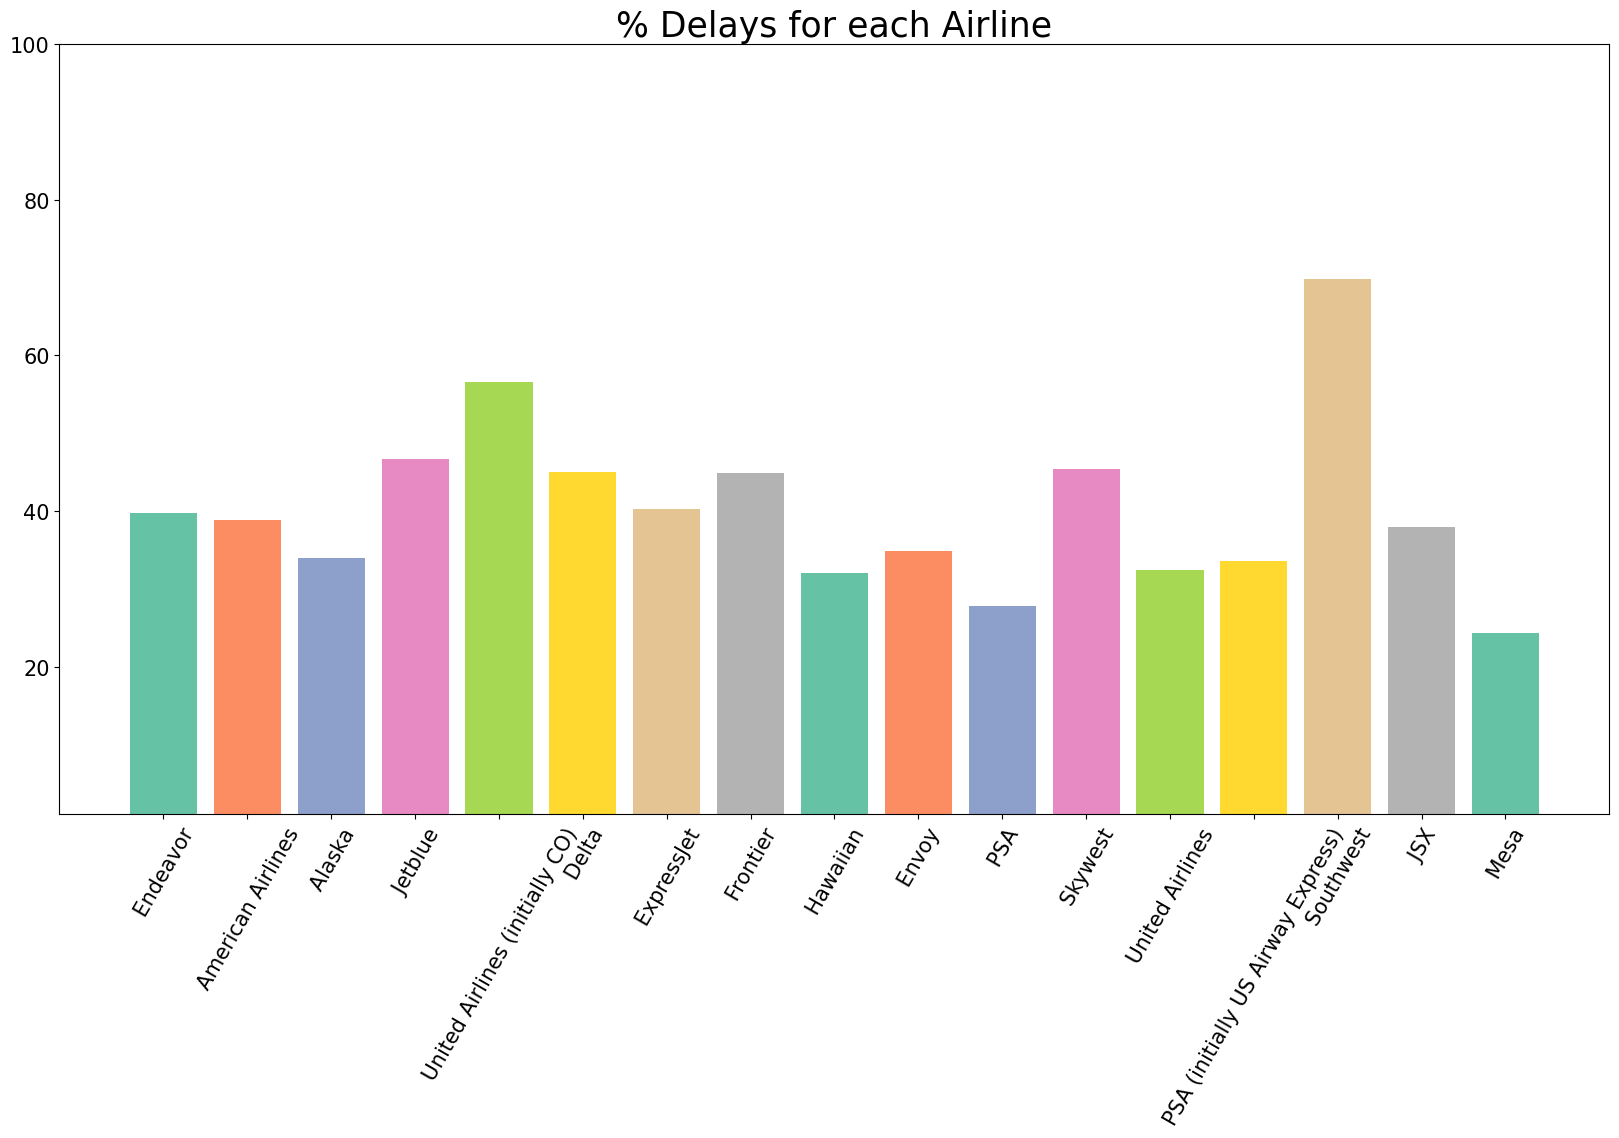

In [87]:
# Plotting a bar chart for a comparative view of delays in all the airlines.

plt.figure(figsize = (20,10))
plt.bar(delay_df.Description, height = delay_df.Delay, color = plt.get_cmap('Set2').colors)
plt.ylim(1,100)
plt.xticks(size = 15, rotation = 60)
plt.yticks(size = 15)
plt.title('% Delays for each Airline', size = 25)
plt.show()

## Flights were delayed on various weekdays. Which day of the week is the safest for travel?

In [88]:
# Lets calculate the % of delays for each airline for each weekday.

delay_pct_weekday = df.groupby('DayOfWeek')['Delay'].agg(pct_delay)
delay_pct_weekday

DayOfWeek
1    47.28
2    45.25
3    47.63
4    45.84
5    42.58
6    40.57
7    45.77
Name: Delay, dtype: float64

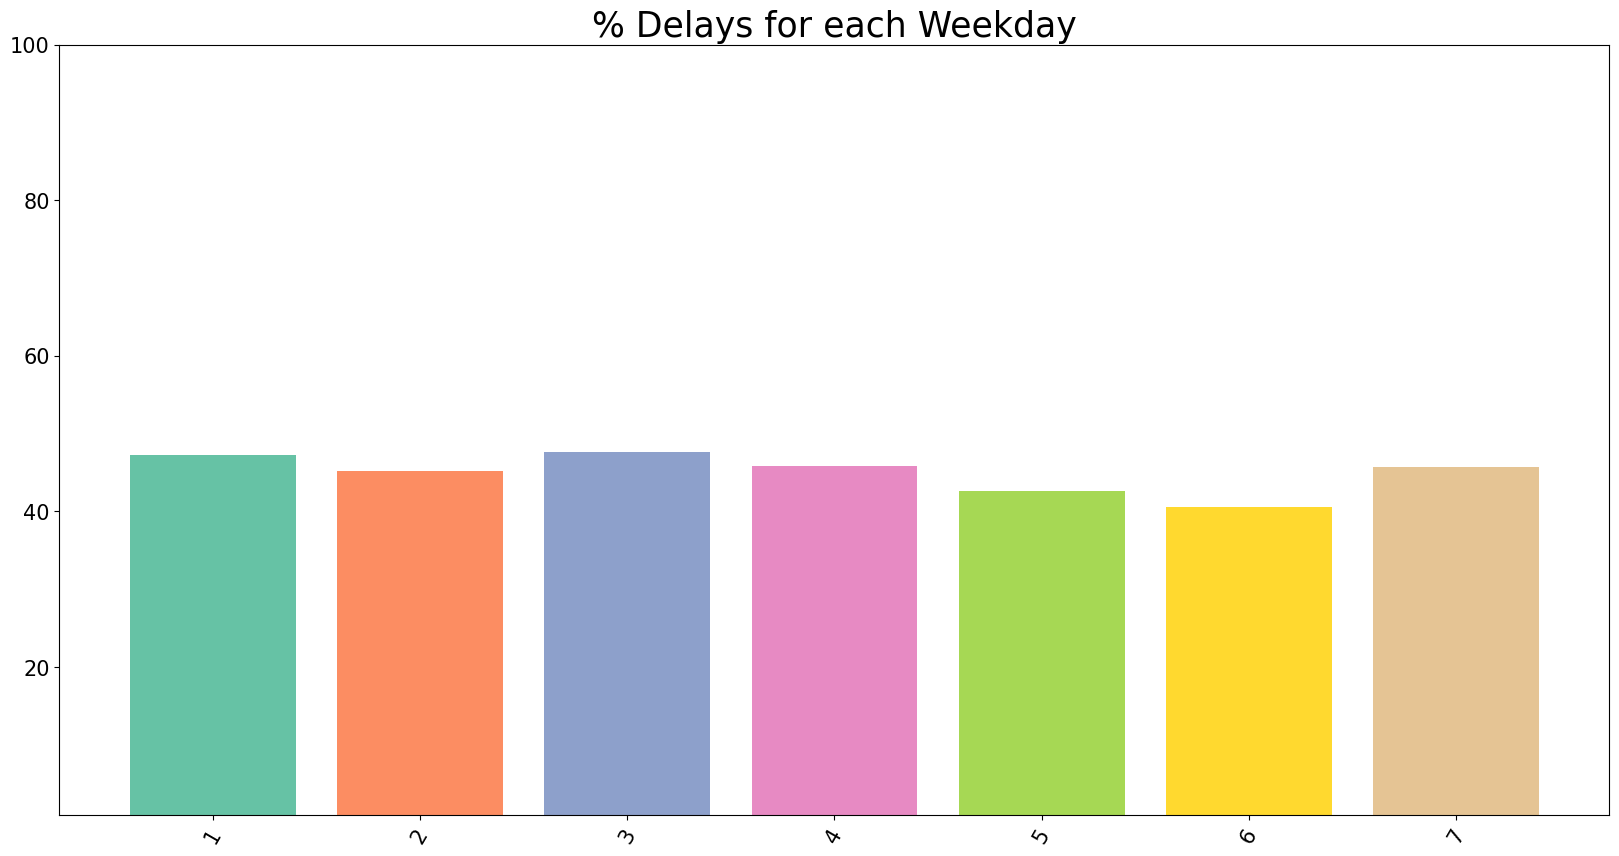

In [89]:
plt.figure(figsize = (20,10))
plt.bar(delay_pct_weekday.index, height = delay_pct_weekday.values, color = plt.get_cmap('Set2').colors)
plt.ylim(1,100)
plt.xticks(size = 15, rotation = 60)
plt.yticks(size = 15)
plt.title('% Delays for each Weekday', size = 25)
plt.show()

From the bar chart above the best days to travel are: Friday(5) and Saturday(6).

In [90]:
duration_df = df[['Airline', 'Length', 'Delay']].copy()

## Which airlines should be recommended for short-, medium-, and long-distance travel?

In [91]:
duration_df['duration'] = pd.cut(duration_df.Length, 3, labels = ['short', 'medium', 'long'])
duration_df_grp= duration_df.groupby(['Airline', 'duration'])['Delay'].agg(pct_delay).reset_index().pivot(index = 'Airline', columns = 'duration').fillna(0)['Delay']
duration_df_grp.columns = duration_df_grp.columns.astype(str)
duration_df_grp.reset_index()

duration,Airline,short,medium,long
0,9E,39.78,0.00,0.00
1,AA,37.61,43.25,60.40
2,AS,32.58,38.17,0.00
3,B6,45.70,51.05,0.00
4,CO,52.82,64.95,66.87
5,DL,43.87,50.24,48.62
6,EV,40.20,50.00,0.00
7,F9,45.04,43.56,0.00
8,HA,30.16,40.48,0.00
9,MQ,34.81,27.42,0.00


In [92]:
airline_dict.Description = airline_dict.Description.str.strip()
duration_df_grp = pd.merge(duration_df_grp, airline_dict[['Airlines ID', 'Description']], how = 'left', left_on = 'Airline', right_on = 'Airlines ID')
duration_df_grp

,short,medium,long,Airlines ID,Description
0,39.78,0.00,0.00,9E,Endeavor
1,37.61,43.25,60.40,AA,American Airlines
2,32.58,38.17,0.00,AS,Alaska
3,45.70,51.05,0.00,B6,Jetblue
4,52.82,64.95,66.87,CO,United Airlines (initially CO)
5,43.87,50.24,48.62,DL,Delta
6,40.20,50.00,0.00,EV,ExpressJet
7,45.04,43.56,0.00,F9,Frontier
8,30.16,40.48,0.00,HA,Hawaiian
9,34.81,27.42,0.00,MQ,Envoy


In [93]:
long = duration_df_grp[duration_df_grp.long == duration_df_grp.long.min()].Description.values.tolist()
print('Airlines with no delays for long flights: \n',', '.join(long))
medium = duration_df_grp[duration_df_grp.medium == duration_df_grp.medium.min()].Description.values.tolist()
print('Airlines with no delays for medium flights: \n',', '.join(medium))
short = duration_df_grp[duration_df_grp.short == duration_df_grp.short.min()].Description.values.tolist()
print('Airlines with no delays for short flights: \n',', '.join(short))

Airlines with no delays for long flights: 
 Endeavor, Alaska, Jetblue, ExpressJet, Frontier, Hawaiian, Envoy, PSA, Skywest, PSA (initially US Airway Express), Southwest, JSX, Mesa
Airlines with no delays for medium flights: 
 Endeavor
Airlines with no delays for short flights: 
 Mesa


For every type of trip distance, the following airlines are advised as the safest options with the fewest delays:
- Long flights (0% delay): Endeavor, Alaska, Jetblue, ExpressJet, Frontier, Hawaiian, Envoy, PSA, Skywest, PSA (initially US Airway Express), Southwest, JSX, Mesa
- Medium flights (0% delays): Endeavor
- Short flights (24.37% delays): Mesa

## Do you notice any patterns in the departure times of long-duration flights?

In [94]:
df['duration'] = pd.cut(df.Length, 3, labels = ['short', 'medium', 'long'])
df.head(10)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_cnt_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_cnt_dest_airport,data_source_2023,data_dest_2023,Founded,Airlines ID,Description,duration
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,24191117.0,22228829.0,1934.0,CO,United Airlines (initially CO),short
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0,23880446.0,25896193.0,1967.0,US,PSA (initially US Airway Express),medium
2,3,AA,2400,LAX,DFW,3,20,165,1,large_airport,125.0,4.0,large_airport,607.0,7.0,36676975.0,39246196.0,1926.0,AA,American Airlines,short
3,4,AA,2466,SFO,DFW,3,20,195,1,large_airport,13.0,4.0,large_airport,607.0,7.0,24191117.0,39246196.0,1926.0,AA,American Airlines,short
4,5,AS,108,ANC,SEA,3,30,202,0,large_airport,152.0,3.0,large_airport,433.0,4.0,2681811.0,24594202.0,1932.0,AS,Alaska,short
5,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,36676975.0,22228829.0,1934.0,CO,United Airlines (initially CO),short
6,7,DL,1768,LAX,MSP,3,30,220,0,large_airport,125.0,4.0,large_airport,841.0,4.0,36676975.0,17019086.0,1924.0,DL,Delta,medium
7,8,DL,2722,PHX,DTW,3,30,228,0,large_airport,1135.0,3.0,large_airport,645.0,6.0,23880446.0,15378558.0,1924.0,DL,Delta,medium
8,9,DL,2606,SFO,MSP,3,35,216,1,large_airport,13.0,4.0,large_airport,841.0,4.0,24191117.0,17019086.0,1924.0,DL,Delta,short
9,10,AA,2538,LAS,ORD,3,40,200,1,large_airport,2181.0,4.0,large_airport,672.0,11.0,27896019.0,35843081.0,1926.0,AA,American Airlines,short


In [95]:
pd.crosstab(df.Time, df.duration)['long']

Time
10      0
15      0
20      0
21      0
25      0
       ..
1428    0
1430    0
1431    0
1435    0
1439    0
Name: long, Length: 1131, dtype: int64

In [96]:
x = pd.crosstab(df.Time, df.duration)['long'].values
y = pd.crosstab(df.Time, df.duration)['long'].index

In [97]:
filter_df = df.loc[df.duration == 'long', ['Time', 'duration']]
filter_df.Time.describe()

count     559.000000
mean      840.635063
std       221.020092
min       540.000000
25%       670.000000
50%       717.000000
75%      1045.000000
max      1310.000000
Name: Time, dtype: float64

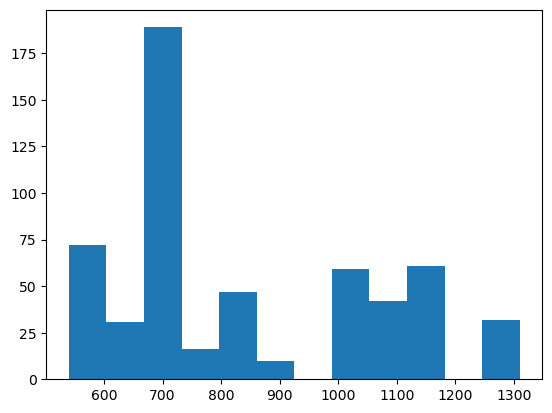

In [98]:
plt.hist(filter_df.Time, bins = 12)
plt.show()

- Maximum number of flights are departing at ~700 minutes, i.e. around 11:40 AM.
- There are two empty time zones, ~(900-1000) and ~(1160-1240) when no long distances flights depart.

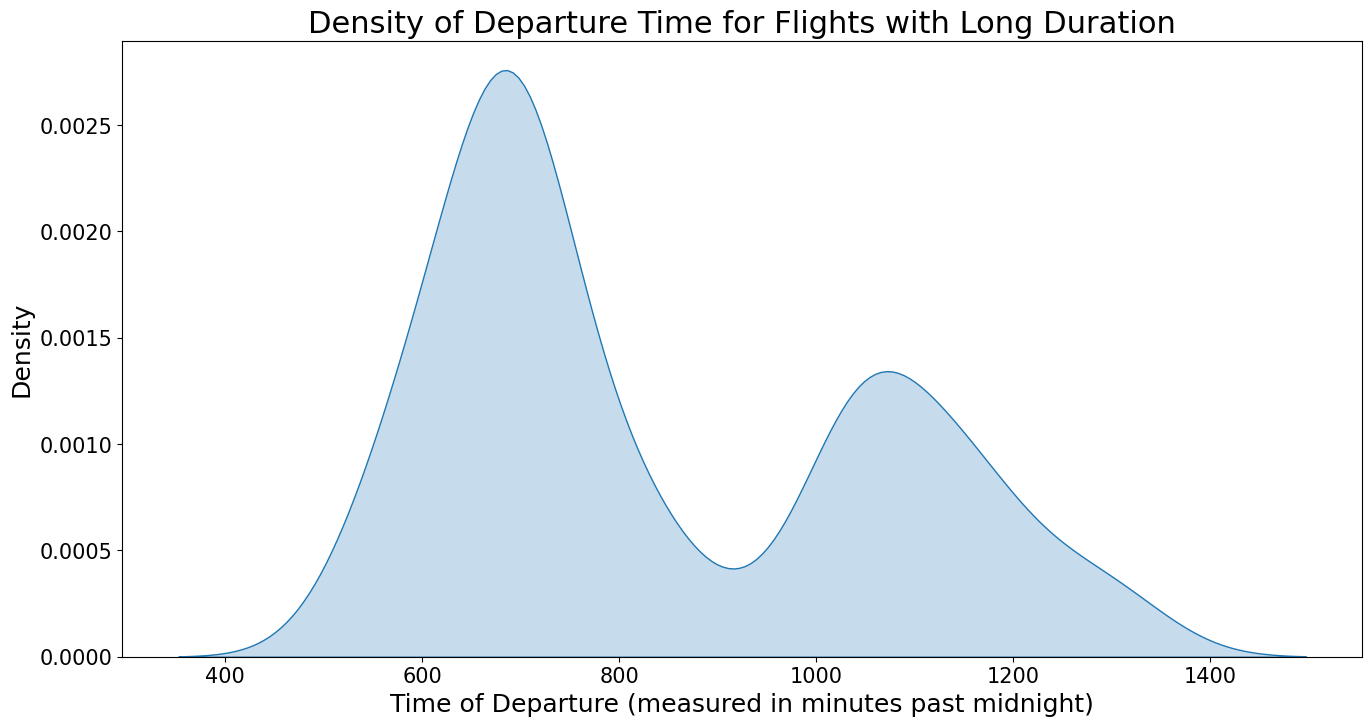

In [99]:
long_duration = filter_df[filter_df['duration'] == 'long']
plt.figure(figsize = (16,8))
sns.kdeplot(data = long_duration, x = 'Time', fill = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel('Time of Departure (measured in minutes past midnight)', size = 18)
plt.ylabel('Density', size = 18)
plt.title('Density of Departure Time for Flights with Long Duration', size = 22)
plt.show()

The KDE figure validates the observations mentioned earlier.

# How many flights were delayed at large hubs compared to medium hubs? Use appropriate visualization to represent your findings.

<Axes: xlabel='type_source_airport'>

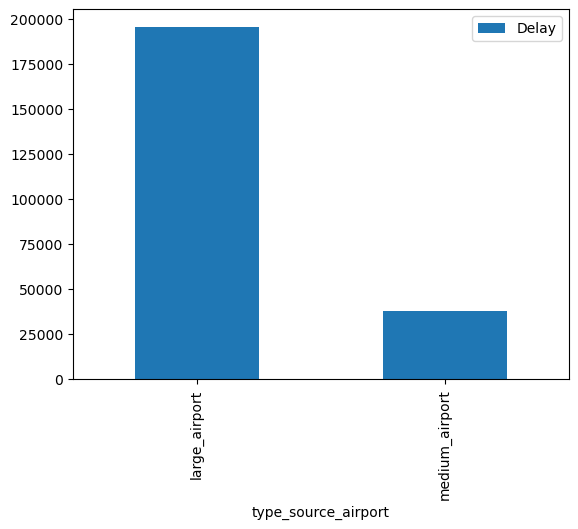

In [100]:
df.groupby('type_source_airport')[['Delay']].agg('sum').plot.bar()

<Axes: xlabel='type_dest_airport'>

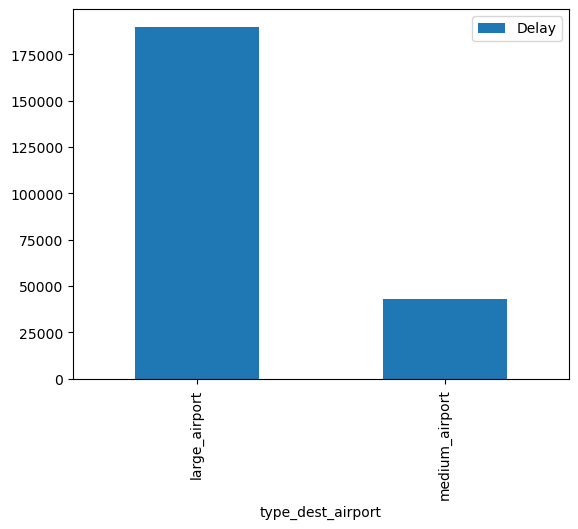

In [101]:
df.groupby('type_dest_airport')[['Delay']].agg('sum').plot.bar()

In [102]:
df.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'type_source_airport',
       'elevation_ft_source_airport', 'runway_cnt_source_airport',
       'type_dest_airport', 'elevation_ft_dest_airport',
       'runway_cnt_dest_airport', 'data_source_2023', 'data_dest_2023',
       'Founded', 'Airlines ID', 'Description', 'duration'],
      dtype='object')

# Use hypothesis testing strategies to discover:

## If the airport's altitude has anything to do with flight delays for incoming and departing flights

In [103]:
# H0 = "Average elevation for outgoing Delayed and Not Delayed flights is not significantly different"
# Ha = "Average elevation for outgoing Delayed and Not Delayed flights is significantly different"

In [104]:
samp_1 = df[df.Delay == 1].elevation_ft_source_airport
samp_2 = df[df.Delay == 0].elevation_ft_source_airport

In [105]:
t, p = stats.ttest_ind(samp_1, samp_2)

In [106]:
if p < 0.05:
    result = 'reject null (H0)'
else:
    result = 'reject assumption (Ha)'
    
print(result)

reject null (H0)


In [107]:
# H0 = "Average elevation for incoming Delayed and Not Delayed flights is not significantly different"
# Ha = "Average elevation for incoming Delayed and Not Delayed flights is significantly different"

In [108]:
samp_1 = df[df.Delay == 1].elevation_ft_dest_airport
samp_2 = df[df.Delay == 0].elevation_ft_dest_airport

In [109]:
t, p = stats.ttest_ind(samp_1, samp_2)

In [110]:
if p < 0.05:
    result = 'reject null (H0)'
else:
    result = 'reject assumption (Ha)'
    
print(result)

reject null (H0)


For both outgoing and incoming flights, between planes that are delayed and those that are not, there is a statistically significant variation in the average elevation. This implies that aircraft delays could be influenced by the airport's elevation.

## If the number of runways at an airport affects flight delays

In [111]:
# H0 = "Number of runways for outgoing flights does not affect flight delays"
# Ha = "Number of runways for outgoing flights does affect flight delays"

In [112]:
samp_1 = df[df.Delay == 1].runway_cnt_source_airport
samp_2 = df[df.Delay == 0].runway_cnt_source_airport

In [113]:
t, p = stats.ttest_ind(samp_1, samp_2)

In [114]:
if p < 0.05:
    result = 'reject null (H0)'
else:
    result = 'reject assumption (Ha)'
    
print(result)

reject null (H0)


In [115]:
# H0 = "Number of runways for incoming flights does not affect flight delays"
# Ha = "Number of runways for incoming flights does affect flight delays"

In [116]:
samp_1 = df[df.Delay == 1].runway_cnt_dest_airport
samp_2 = df[df.Delay == 0].runway_cnt_dest_airport

In [117]:
t, p = stats.ttest_ind(samp_1, samp_2)

In [118]:
if p < 0.05:
    result = 'reject null (H0)'
else:
    result = 'reject assumption (Ha)'
    
print(result)

reject null (H0)


Since the average runway count for delayed flights is substantially lower than the average runway count for non-delayed flights in both the source and destination airports, the output labeled "reject null" for both tests indicates that there is evidence to support the alternative hypothesis.

## If the duration of a flight (length) affects flight delays

In [119]:
# H0 = "Duration of a flight(length) does not affect flight delays"
# Ha = "Duration of a flight(length) does affect flight delays"

In [120]:
samp_1 = df[df.Delay == 1].Length
samp_2 = df[df.Delay == 0].Length

In [121]:
t, p = stats.ttest_ind(samp_1, samp_2)

In [122]:
if p < 0.05:
    result = 'reject null (H0)'
else:
    result = 'reject assumption (Ha)'
    
print(result)

reject null (H0)


The result is 'reject null', indicating that there is a significant difference in the average duration between delayed and non-delayed flights.

# Find the correlation matrix between the flight delay predictors, create a heatmap to visualize this, and share your findings

In [123]:
num_columns = df.select_dtypes(include = ['float64', 'int64']).columns
corr_with_delay = df[num_columns].corr()['Delay']
corr_with_delay

id                             0.140434
Flight                        -0.057371
DayOfWeek                     -0.025832
Time                           0.149801
Length                         0.040162
Delay                          1.000000
elevation_ft_source_airport    0.012551
runway_cnt_source_airport      0.029099
elevation_ft_dest_airport      0.013180
runway_cnt_dest_airport       -0.061431
data_source_2023               0.022366
data_dest_2023                -0.047837
Founded                       -0.002103
Name: Delay, dtype: float64

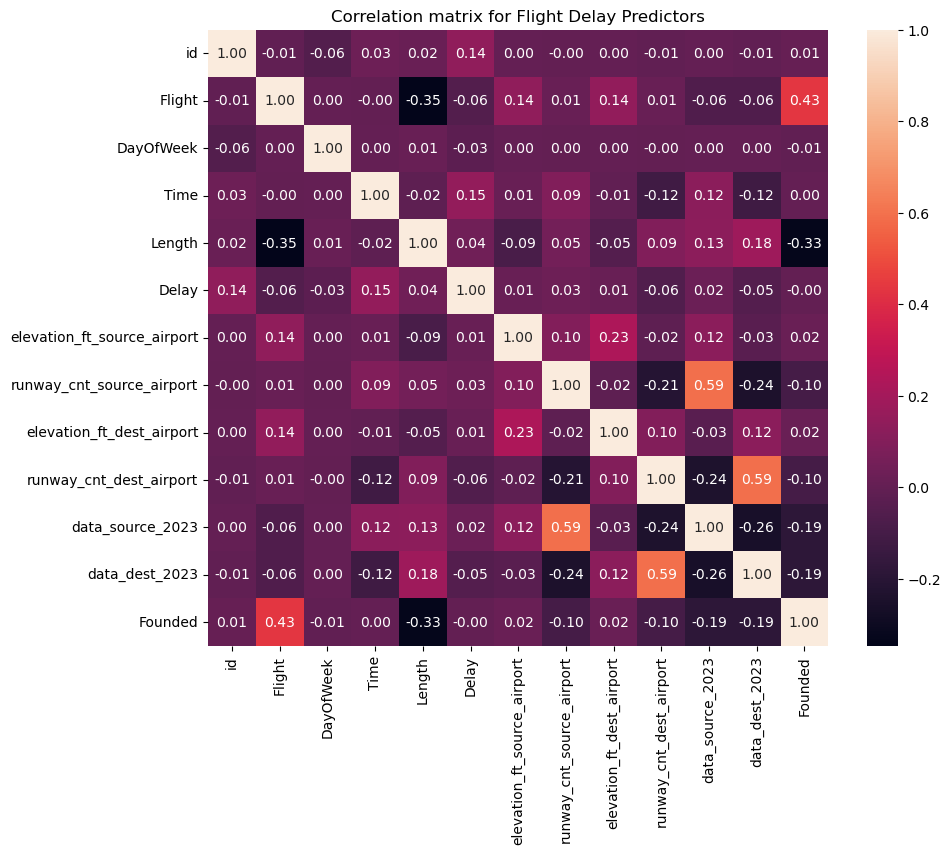

In [124]:
corr_df_mat = df[num_columns].corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr_df_mat, annot = True, fmt = ".2f")
plt.title('Correlation matrix for Flight Delay Predictors')
plt.show()

Observations:

- The 'Time' variable has the highest positive correlation with 'Delay' (0.149801), indicating that flights scheduled for later times may have a higher likelihood of being delayed.
- The 'Length' variable has a slightly positive correlation with 'Delay' (0.040162), suggesting that longer flights may be associated with a slightly higher chance of delays.
- The 'Flight' variable shows a weak negative correlation with 'Delay' (-0.057371), implying that certain flight numbers may be associated with a lower likelihood of delays.
- The 'runway_cnt_dest_airport' variable has a moderate negative correlation with 'Delay' (-0.061431), indicating that airports with a higher number of runways at the destination may be associated with a lower probability of delays.
- Other variables such as 'DayOfWeek', 'elevation_ft_source_airport', 'elevation_ft_dest_airport', 'data_source_2023', 'data_dest_2023', and 'Founded' show weak correlations with 'Delay'.

In [125]:
df.to_csv('USA_Airlines_final_data', index = False)

In [126]:
df.isna().sum()

id                             0
Airline                        0
Flight                         0
AirportFrom                    0
AirportTo                      0
DayOfWeek                      0
Time                           0
Length                         0
Delay                          0
type_source_airport            0
elevation_ft_source_airport    0
runway_cnt_source_airport      0
type_dest_airport              0
elevation_ft_dest_airport      0
runway_cnt_dest_airport        0
data_source_2023               0
data_dest_2023                 0
Founded                        0
Airlines ID                    0
Description                    0
duration                       0
dtype: int64

In [127]:
df.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'type_source_airport',
       'elevation_ft_source_airport', 'runway_cnt_source_airport',
       'type_dest_airport', 'elevation_ft_dest_airport',
       'runway_cnt_dest_airport', 'data_source_2023', 'data_dest_2023',
       'Founded', 'Airlines ID', 'Description', 'duration'],
      dtype='object')

In [128]:
df.drop(columns = ['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'duration'], inplace = True)
df.head()

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_cnt_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_cnt_dest_airport,data_source_2023,data_dest_2023,Founded,Airlines ID,Description
0,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,24191117.0,22228829.0,1934.0,CO,United Airlines (initially CO)
1,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0,23880446.0,25896193.0,1967.0,US,PSA (initially US Airway Express)
2,3,20,165,1,large_airport,125.0,4.0,large_airport,607.0,7.0,36676975.0,39246196.0,1926.0,AA,American Airlines
3,3,20,195,1,large_airport,13.0,4.0,large_airport,607.0,7.0,24191117.0,39246196.0,1926.0,AA,American Airlines
4,3,30,202,0,large_airport,152.0,3.0,large_airport,433.0,4.0,2681811.0,24594202.0,1932.0,AS,Alaska


# Use OneHotEncoder and OrdinalEncoder to deal with categorical variables

In [129]:
df.type_source_airport.unique()

array(['large_airport', 'medium_airport'], dtype=object)

In [130]:
df.type_dest_airport.unique()

array(['large_airport', 'medium_airport'], dtype=object)

In [131]:
ordinal_enc = OrdinalEncoder(categories = [['medium_airport','large_airport'],['medium_airport','large_airport']])
ordinal_enc.fit(df[['type_source_airport', 'type_dest_airport']])

OrdinalEncoder(categories=[['medium_airport', 'large_airport'],
                           ['medium_airport', 'large_airport']])

In [132]:
df[['type_source_airport', 'type_dest_airport']] = ordinal_enc.transform(df[['type_source_airport', 'type_dest_airport']])

In [133]:
df.head()

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_cnt_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_cnt_dest_airport,data_source_2023,data_dest_2023,Founded,Airlines ID,Description
0,3,15,205,1,1.0,13.0,4.0,1.0,97.0,5.0,24191117.0,22228829.0,1934.0,CO,United Airlines (initially CO)
1,3,15,222,1,1.0,1135.0,3.0,1.0,748.0,4.0,23880446.0,25896193.0,1967.0,US,PSA (initially US Airway Express)
2,3,20,165,1,1.0,125.0,4.0,1.0,607.0,7.0,36676975.0,39246196.0,1926.0,AA,American Airlines
3,3,20,195,1,1.0,13.0,4.0,1.0,607.0,7.0,24191117.0,39246196.0,1926.0,AA,American Airlines
4,3,30,202,0,1.0,152.0,3.0,1.0,433.0,4.0,2681811.0,24594202.0,1932.0,AS,Alaska


In [134]:
df['years_of_exp'] = 2024 - df['Founded']

In [135]:
df.drop(['Founded', 'Airlines ID', 'Description'], axis = 1, inplace = True)

In [136]:
df.head()

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_cnt_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_cnt_dest_airport,data_source_2023,data_dest_2023,years_of_exp
0,3,15,205,1,1.0,13.0,4.0,1.0,97.0,5.0,24191117.0,22228829.0,90.0
1,3,15,222,1,1.0,1135.0,3.0,1.0,748.0,4.0,23880446.0,25896193.0,57.0
2,3,20,165,1,1.0,125.0,4.0,1.0,607.0,7.0,36676975.0,39246196.0,98.0
3,3,20,195,1,1.0,13.0,4.0,1.0,607.0,7.0,24191117.0,39246196.0,98.0
4,3,30,202,0,1.0,152.0,3.0,1.0,433.0,4.0,2681811.0,24594202.0,92.0


In [137]:
df.shape

(516217, 13)

# Perform the following model building steps:
## Split data into train and test
## Standardize data
## Apply logistic regression (use stochastic gradient descent optimizer) and decision tree models
Note: Make sure you use standardization effectively, ensuring no data leakage and leverage pipelines to have a cleaner code
## Check accuracy report of model on train and test data
## Take care of overfitting of decision tree model
Note: The final prediction will be based on the voting (majority class by 5 models created using the stratified 5-fold method)
## Compare the results of logistic regression and decision tree classifier


In [138]:
model_df = df.copy()
model_df.head()

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_cnt_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_cnt_dest_airport,data_source_2023,data_dest_2023,years_of_exp
0,3,15,205,1,1.0,13.0,4.0,1.0,97.0,5.0,24191117.0,22228829.0,90.0
1,3,15,222,1,1.0,1135.0,3.0,1.0,748.0,4.0,23880446.0,25896193.0,57.0
2,3,20,165,1,1.0,125.0,4.0,1.0,607.0,7.0,36676975.0,39246196.0,98.0
3,3,20,195,1,1.0,13.0,4.0,1.0,607.0,7.0,24191117.0,39246196.0,98.0
4,3,30,202,0,1.0,152.0,3.0,1.0,433.0,4.0,2681811.0,24594202.0,92.0


In [139]:
model_df.reset_index(drop = True, inplace = True)

In [140]:
# Generating a randon set of indices. 

np.random.seed(12)
deploy_idx = np.random.choice(model_df.index, replace = False, size = 5000)

In [141]:
deploy_df = model_df.loc[deploy_idx]

In [142]:
X_deploy = deploy_df.drop(columns = 'Delay')

In [143]:
model_dev_df = model_df.loc[~model_df.index.isin(deploy_df.index)]

In [144]:
deploy_df.reset_index(drop = True, inplace = True)
model_dev_df.reset_index(drop = True, inplace = True)

In [145]:
X = model_dev_df.drop(columns = 'Delay')
y = model_dev_df.Delay

In [146]:
def create_pipeline(estimator, param_space):
    return Pipeline([('sc', StandardScaler()),('estimator', estimator)]), param_space

In [147]:
def val_cv(X, y, model_dev_df, X_deploy, pipeline, param_space, n_splits = 5, n_iter = 2):
    folds = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 12)
    acc_train, acc_test, final_pred = {}, {}, {}
    
    for i, (train_idx, test_idx) in enumerate(folds.split(X, y), 1):
        print(f'Iteration {i}')
        train, test = model_dev_df.loc[train_idx], model_dev_df.loc[test_idx]
        
        # Define search using RandomizedSearchCV
        search_cv= RandomizedSearchCV(pipeline, param_space, scoring = 'accuracy', cv = 5, refit = True, return_train_score = True, random_state = 12,
                                     n_jobs = -1, n_iter = n_iter)
        # Execute search
        X_train, y_train = train.drop(columns = 'Delay'), train.Delay
        X_test, y_test = test.drop(columns = 'Delay'), test.Delay
        
        result = search_cv.fit(X_train, y_train)
        train_pred = result.predict(X_train)
        test_pred = result.predict(X_test)
        
        final_pred[f'Fold{i}'] = result.predict(X_deploy)
        acc_train[f'Fold{i}'] = round(accuracy_score(y_train, train_pred) * 100, 3)
        acc_test[f'Fold{i}'] = round(accuracy_score(y_test, test_pred) * 100, 3)
        
    return acc_train, acc_test, final_pred    

In [148]:
# Define model configurations

models = {
    'sgd' : (SGDClassifier(), {
        'estimator__penalty' : ['l1', 'l2', 'elasticnet'],
        'estimator__l1_ratio' : [0, .1, .2, .8, 1],
        'estimator__alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000],
        'estimator__learning_rate' : ['constant', 'adaptive'],
        'estimator__eta0' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 2e-1, 3e-1, 5e-1, 8e-1, 4e-1, 8e-1, 1, 10, 100]
    }),
    'dt' : (DecisionTreeClassifier(), {
        'estimator__min_samples_split' : [25000, 30000, 35000, 40000, 45000, 50000, 60000],
        'estimator__min_samples_leaf' : [10000, 15000, 20000]
    }),
    'xgb' : (XGBClassifier(random_state = 12, use_label_encoder = False), {
        'estimator__n_estimators' : [40, 50, 60],
        'estimator__max_depth' : [3, 4, 5],
        'estimator__colsample_bytree' : [0.4, 0.5, 0.6],
        'estimator__lambda' : [0.0001, 0.002, 0.0004, 0.0003],
        'estimator__alpha' : [0.1, 0.02, 0.1, 0.4]
    })
}

In [149]:
# Run cross-validation for each model

results = {}
for model_name, (estimator, param_space) in models.items():
    pipeline, param_space = create_pipeline(estimator, param_space)
    results[model_name] = val_cv(X, y, model_dev_df, X_deploy, pipeline, param_space)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 1


C:\Users\tyagi\anaconda3\envs\ml_env\lib\site-packages\xgboost\core.py:158: UserWarning: [20:03:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 2


C:\Users\tyagi\anaconda3\envs\ml_env\lib\site-packages\xgboost\core.py:158: UserWarning: [20:03:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 3


C:\Users\tyagi\anaconda3\envs\ml_env\lib\site-packages\xgboost\core.py:158: UserWarning: [20:03:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 4


C:\Users\tyagi\anaconda3\envs\ml_env\lib\site-packages\xgboost\core.py:158: UserWarning: [20:03:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 5


C:\Users\tyagi\anaconda3\envs\ml_env\lib\site-packages\xgboost\core.py:158: UserWarning: [20:03:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [150]:
# Prepare and display results

train_results = pd.DataFrame({model : res[0] for model, res in results.items()})
test_results = pd.DataFrame({model : res[1] for model, res in results.items()})

In [151]:
print("Train Results")
print(train_results)
print("Test Results")
print(test_results)

Train Results
          sgd      dt     xgb
Fold1  57.159  62.130  65.351
Fold2  57.158  61.946  65.283
Fold3  57.156  61.877  65.185
Fold4  57.222  61.616  65.275
Fold5  57.101  61.903  65.269
Test Results
          sgd      dt     xgb
Fold1  57.135  61.914  64.904
Fold2  57.176  61.850  64.862
Fold3  57.209  62.150  65.168
Fold4  56.903  61.395  64.839
Fold5  57.302  62.046  64.958


In [152]:
final_pred_results = pd.DataFrame({model : res[2] for model, res in results.items()})

In [153]:
final_pred_results

,sgd,dt,xgb
Fold1,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
Fold2,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ..."
Fold3,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
Fold4,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
Fold5,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ..."


The XGBoost model with StratifiedKfold validation with 5 folds performs the best as compared to the SGDClassifier and Decision trees model for the same StratifiedKfold validation with 5 folds.

In [156]:
test_results['xgb'].mean()

64.9462